# Project: 1D elementary cellular automata
### Michiel Stock, Bram De Jaegher, Daan Van Hauwermeiren
### 18 December 2019
In this exercise, we simulate elementary one-dimensional cellular automata (CA). It is a simple application, which nevertheless illustrates many of the Julia programming concepts as it has all aspects of an individual-based model.

# What are elementary cellular automata?

Cellular automata are simple dynamical models, discrete in time, space, and state. In elementary cellular automata, the states only take the values 0 or 1. The state of the cell at time $t+1$ is solely determined by the state of that cell at time $t$ and the states of its neighbors. Since these three cells can jointly only take eight unique values, i.e.,

In [1]:
[(l, s, r) for l in 0:1 for s in 0:1 for r in 0:1]

8-element Array{Tuple{Int64,Int64,Int64},1}:
 (0, 0, 0)
 (0, 0, 1)
 (0, 1, 0)
 (0, 1, 1)
 (1, 0, 0)
 (1, 0, 1)
 (1, 1, 0)
 (1, 1, 1)

This means that if we assign one state to each combination, we have $2^8=256$ unique elementary cellular automata. Naturally, many of them are equivalent up to some symmetry, but there is quite some diversity in behavior among these different classes.

An integer between 0 and 255 solely defines every elementary cellular automaton. The binary representation of this number determines the state updates. This is best explained by showing some examples.

![Some example of the elementary CA rules. Every integer between 0 and 255 (in binary) represents a rule.](../figures/CArules.png)

So starting from an initial state vector, we can represent the evolution of the states by a space-time diagram.

![Example of the rules applied consequently with an initial state of only one active cell.](../figures/CAexamples.png)

In implementing an elementary CA, we use cyclic boundary conditions. Here, we wrap the state vector around a circle: the right neighbor of the last cell is again the first cell (and *vice versa*).

# A basic implementation

## Update rule

We start by implementing the updating rule from a single state to the next. This can be implemented in a variety of ways, but let us provide one that is reasonably concise and efficient. It will also nicely illustrate some aspects of Julia's type system.

Updating a cell depends only on the state of the cell and its two neighbors. Let us use three Boolean variables `(l, s, r)` to denote them. Here `s` is the state of the cell of interest, and `l` and `r` are the states of its left and right neighbor, respectively. An integer between 0 and 255 can represent the rule, hence an 8-bit number. The rule for updating a state is implemented below.

In [2]:
nextstate(l::Bool, s::Bool, r::Bool, rule::Int8) = bitstring(rule)[8-(4r+2s+1r)] == '1';

Here, we have cleverly made use of the function `bitstring`, which transforms an 8-bit number in the corresponding bitstring.

In [3]:
bitstring(Int8(42))

"00101010"

The three Boolean variables are transformed into the correct index of this string. We might save ourselves the bother of ensuring that the argument `rule` is of the type `Int8` using dispatch.

In [4]:
nextstate(l::Bool, s::Bool, r::Bool, rule::Integer) = nextstate(l, s, r, Int8(rule));

> **Assignment**: Create an 8 by 3 matrix `S` containing all possible states of three adjacent cells. Complete the function `nextstates`, which returns a vector containing the next state of the middle cell.

In [5]:
rule = 110

110

In [6]:
S = vcat([[l s r] for l in 0:1 for s in 0:1 for r in 0:1]...) .== 1

8×3 BitArray{2}:
 false  false  false
 false  false   true
 false   true  false
 false   true   true
  true  false  false
  true  false   true
  true   true  false
  true   true   true

In [7]:
function nextstates(S, rule)
  states = [nextstate(S[i,1], S[i,2], S[i,3], rule) for i in 1:size(S,1)]
  return states
end

nextstates (generic function with 1 method)

In [8]:
nextstates(S, rule)

8-element Array{Bool,1}:
 false
  true
  true
 false
 false
  true
  true
 false

## Simulating a 1D CA model

We will represent the states of our system using a binary vector (type is `BitVector`) `x`.
Efficient functions often work in-place, because memory is already allocated. We will construct a function `next!`, which takes the current state vector `x` and a vector to store the next states in a binary vector `xnew` for a given rule. This function uses cyclic boundaries.

> **Assignment**: Complete the function `next!`.

In [9]:
"""
  next!(xnew, x, rule)

Updates a state vector `x` according to `rule` and stores the result in `xnew`.
"""
function next!(xnew, x, rule)
  # boundaries
    xnew[1] = nextstate(x[end], x[1], x[2], rule)
    xnew[end] = nextstate(x[end-1], x[end], x[1], rule)
    # annotations for speed, remove if unclear!
    #UNSAFE BUT FAST
    @simd for i in 2:length(x)-1
        @inbounds xnew[i] = nextstate(x[i-1], x[i], x[i+1], rule)
    end
  return xnew
end

next!

> **Optional assignment**: Make a simular function `next`, which only takes as arguments `x` and `rule`, i.e. this function allocates a new vector for the result.

In [10]:
next(x, rule) = next!(similar(x), x, rule)

next (generic function with 1 method)

Now that we can simulate a single time step, let us write a function to simulate for several time steps.

In [11]:
"""
    simulate(x₀, rule; nsteps::Integer=100)

Simulate `nsteps` time steps according to `rule` with `x₀` as the initial condition.
Returns a matrix X, where the rows are the state vectors at different time steps.
"""
function simulate(x₀, rule; nsteps::Integer=100)
    X = Array{Bool,2}(undef, nsteps+1, length(x₀))
    x = copy(x₀)
    xnew = similar(x)
    X[1,:] .= x
    for t in 2:nsteps+1
        next!(xnew, x, rule)
        X[t,:] .= xnew
        x, xnew = xnew, x
    end
    return X
end

simulate

> **Assignments**
> 1. Complete the function `simulate`.
> 2. Choose a number for the rule. Simulate a elementary CA of size 101 for 100 timesteps. Start from a vector with all elements false, except for the middle cell.
> 3. Visualize the result. This can be done either using `heatmap(1X)` (multiplying by 1 turns the Booleans into numerical values) or the function `printca` given below.

In [12]:
x₀ = [i==51 for i in 1:101]

101-element Array{Bool,1}:
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
     ⋮
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false

In [13]:
function printca(X::Matrix{Bool})
    n, m = size(X)
    for i in 1:n
        println(reduce(*, (s-> s ? "*" : "-").(X[i,:])))
    end
end

printca (generic function with 1 method)

In [14]:
X = simulate(x₀, rule);

printca(X)

--------------------------------------------------*--------------------------------------------------
-------------------------------------------------**--------------------------------------------------
------------------------------------------------*-*--------------------------------------------------
-----------------------------------------------****--------------------------------------------------
----------------------------------------------*---*--------------------------------------------------
---------------------------------------------**--**--------------------------------------------------
--------------------------------------------*-*-*-*--------------------------------------------------
-------------------------------------------********--------------------------------------------------
------------------------------------------*-------*--------------------------------------------------
-----------------------------------------**------**-------------------------------

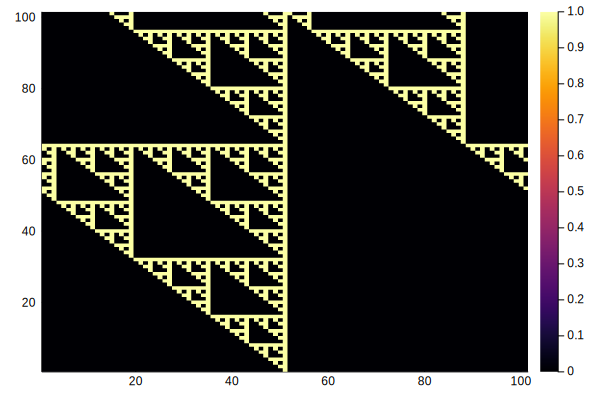

In [15]:
using Plots

heatmap(1X)

# Type-based dispatch for rules

In the previous section, we developed a working implementation of an elementary cellular automaton. Let us rewrite the code, but using type-based dispatch. We implement an abstract type for general CA rules. Then we have a structure `DetCARule` to contain the above elementary CA rules.

In [16]:
abstract type CARule end

struct DetCARule <: CARule
    rulenr::Int8
    function DetCARule(r::Integer)  # custom constructor
        new(Int8(r))
    end
end

> **Assignment** Complete the code for the type-based dispatch of cellular automata. Test it using the same rule as before (or a different one, we don't care).

In [17]:
nextstate(l::Bool, s::Bool, r::Bool, rule::DetCARule) = nextstate(l, s, r, rule.rulenr)

rule = DetCARule(110)

X = simulate(x₀, rule);

printca(X)

--------------------------------------------------*--------------------------------------------------
-------------------------------------------------**--------------------------------------------------
------------------------------------------------*-*--------------------------------------------------
-----------------------------------------------****--------------------------------------------------
----------------------------------------------*---*--------------------------------------------------
---------------------------------------------**--**--------------------------------------------------
--------------------------------------------*-*-*-*--------------------------------------------------
-------------------------------------------********--------------------------------------------------
------------------------------------------*-------*--------------------------------------------------
-----------------------------------------**------**-------------------------------

> **Assignment** Make a new concrete type `StochCARule` to model stochastic elementary cellular automata. This type has an additional field `pflip`, which is the probability of switching the state after applying the rule. Make a custom `nextstate` to deal with this and simulate again correctly.

In [18]:
struct StochCARule <: CARule
    rulenr::Int8
    pflip::Float64
    function StochCARule(r::Integer,pflip::Float64=0.0)  # custom constructor
        @assert 0.0 ≤ pflip ≤ 1.0
        new(Int8(r), pflip)
    end
end

In [19]:
nextstate(l::Bool, s::Bool, r::Bool, rule::StochCARule) = (rule.pflip < rand()) ? nextstate(l, s, r, rule.rulenr) : !nextstate(l, s, r, rule.rulenr)

nextstate (generic function with 4 methods)

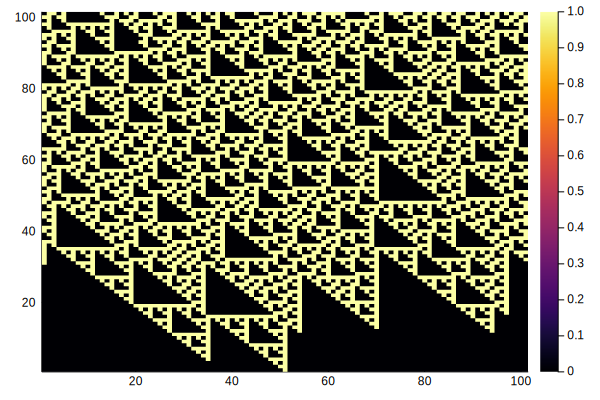

In [20]:
X = simulate(x₀, StochCARule(110, 0.001));

heatmap(1X)

In [21]:
printca(X)

--------------------------------------------------*--------------------------------------------------
-------------------------------------------------**--------------------------------------------------
------------------------------------------------*-*--------------------------------------------------
----------------------------------*------------****--------------------------------------------------
---------------------------------**-----------*---*--------------------------------------------------
--------------------------------*-*----------**--**--------------------------------------------------
-------------------------------****---------*-*-*-*--------------------------------------------------
------------------------------*---*--------********--------------------------------------------------
-----------------------------**--**-------*-------*--------------------------------------------------
----------------------------*-*-*-*------**------**-------------------------------